In [1]:
import scvelo as scv
import numpy as np  
import matplotlib.pyplot as plt

import anndata

import pandas as pd
import scprep

import sys
sys.path.append("..")


import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 
import cellpath.de_analy as de


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

## Meta-cell construction

In [2]:
num_trajs = 6
include_all_cells = True
num_metacells = 400

In [3]:
# read in simulated dataset
# adata = anndata.read_h5ad("./sim_data/Dyngen/Trifurcating.h5ad")
adata = anndata.read_h5ad("../sim_data/Dyngen/Trifurcating_clust.h5ad")

In [4]:
cellpath_obj = cp.CellPath(adata = adata)
cellpath_obj.all_in_one(num_metacells = num_metacells, n_neighs = 10, pruning = False, insertion = include_all_cells, num_trajs = num_trajs)

Already conducted clustering
Meta-cell constructed
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  177_348 , len:  39 newly covered: 39
start_end:  388_281 , len:  37 newly covered: 22
start_end:  250_136 , len:  31 newly covered: 16
start_end:  261_7 , len:  35 newly covered: 12
start_end:  261_79 , len:  37 newly covered: 6
start_end:  177_315 , len:  34 newly covered: 7
start_end:  261_301 , len:  39 newly covered: 2
start_end:  261_158 , len:  39 newly covered: 2
start_end:  261_28 , len:  39 newly covered: 1
start_end:  261_18 , len:  39 newly covered: 1
start_end:  261_154 , len:  39 newly covered: 1
start_end:  261_118 , len:  38 newly covered: 1
start_end:  261_121 , len:  38 newly covered: 1
Finished
Cell-level pseudo-time inferred


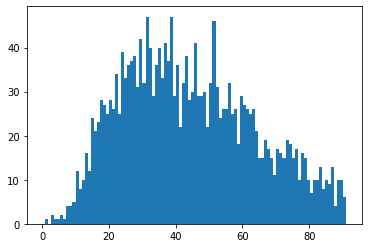

In [5]:
visual.weight_histogram(cellpath_obj, resolution = 100)

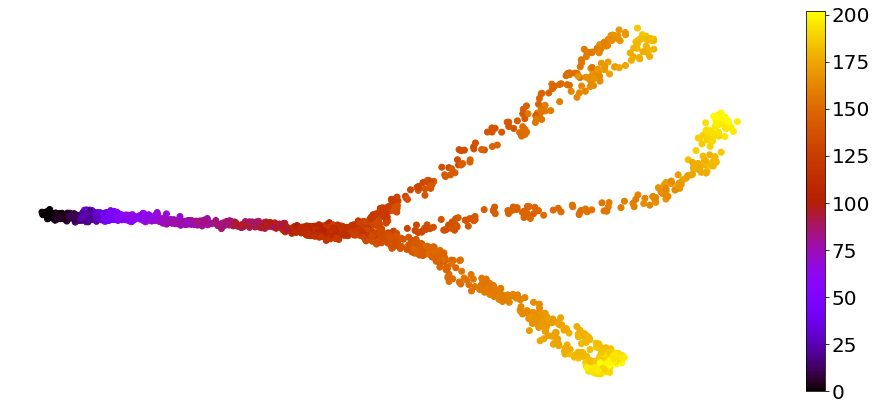

In [6]:
visual.plot_data(cellpath_obj, basis = "pca", figsize = (15,7), save_as = None)

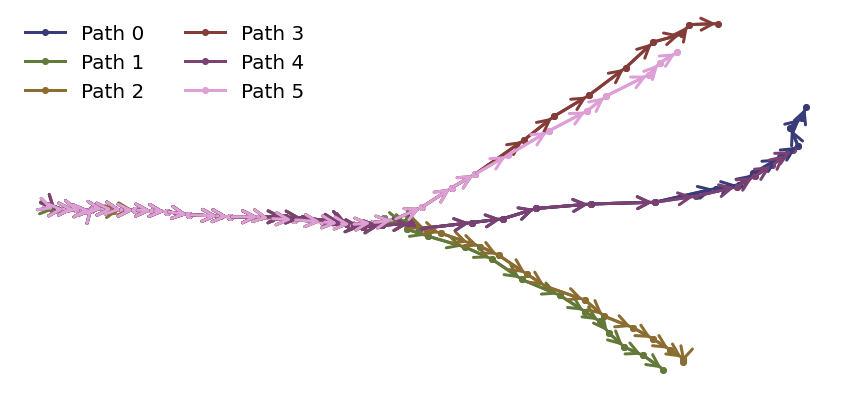

In [7]:
visual.meta_traj_visual(cellpath_obj, basis = "pca", trajs = num_trajs, figsize = (15,7), save_as = None, legend_pos = "upper left", axis = False)

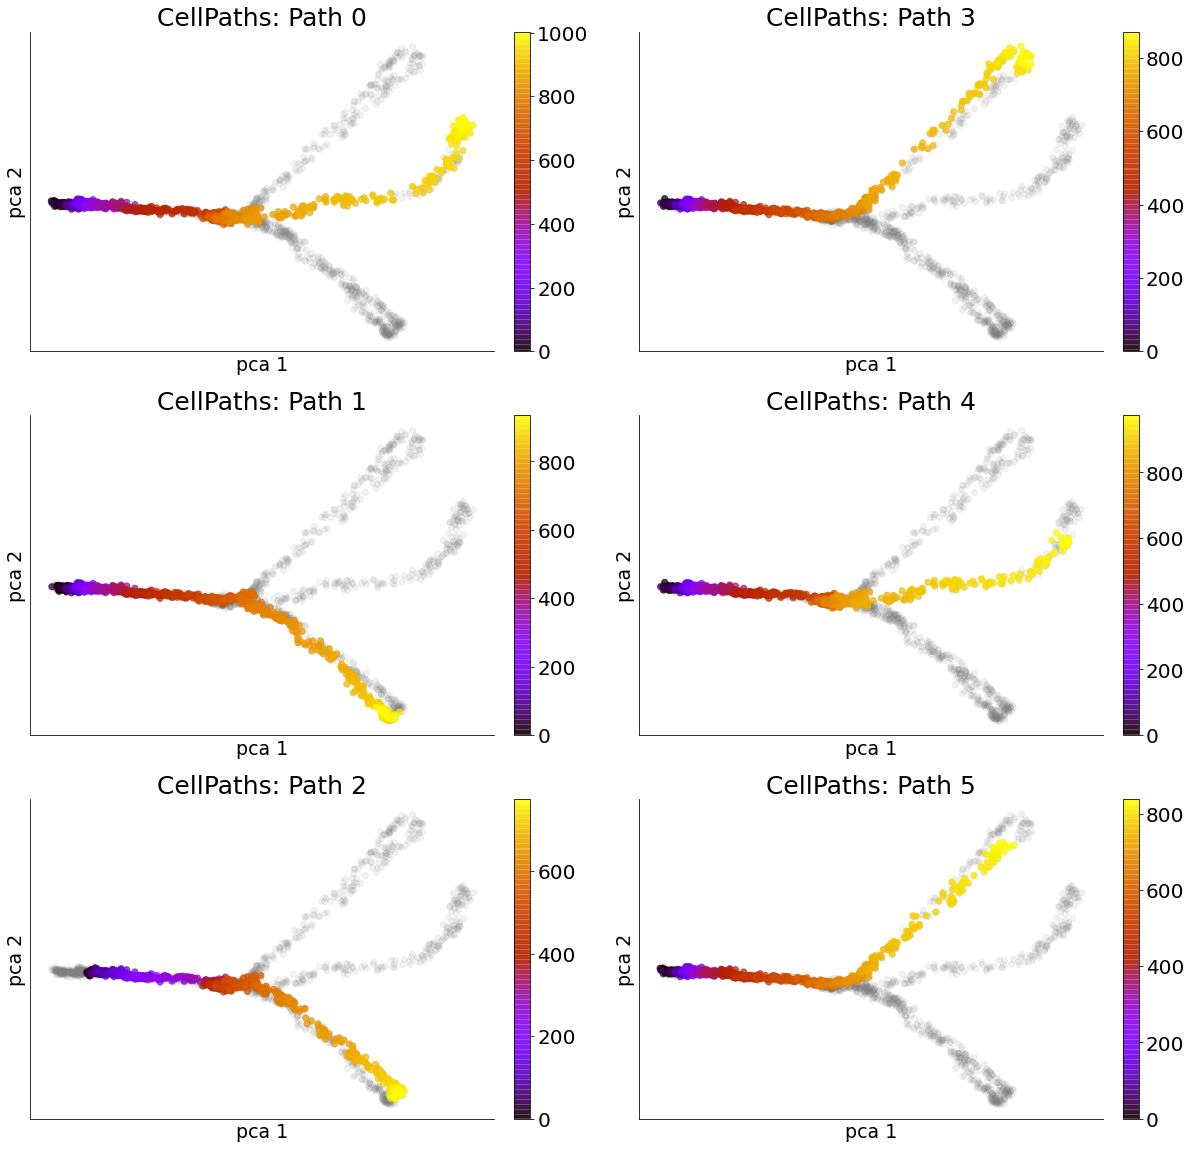

In [8]:
visual.first_order_approx_pt(cellpath_obj, basis = "pca", trajs = num_trajs, figsize = (20,20), save_as = None)

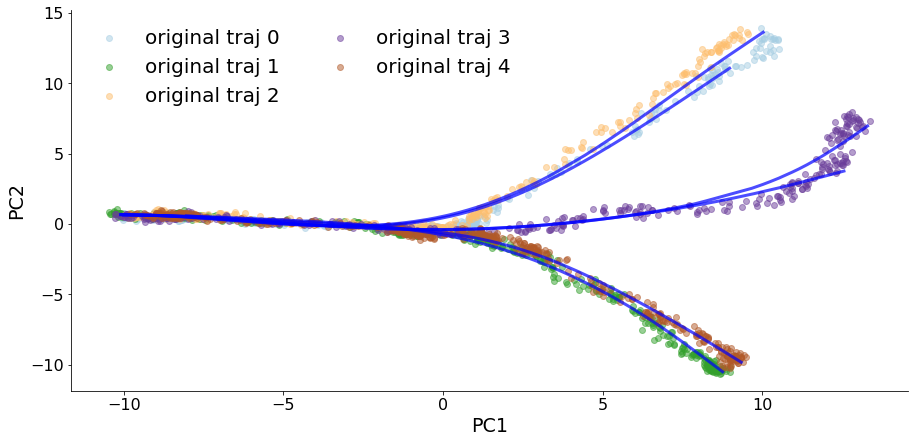

In [9]:
visual.traj_visual(cellpath_obj, trajs = num_trajs, figsize = (15,7), cmap = "Paired", save_as = None)

# Benchmark
## CellPaths
### Kendall-tau test


In [10]:
kt = bmk.cellpath_kt(cellpath_obj)

### Topology


In [11]:
f1 = bmk.f1_score(cellpath_obj = cellpath_obj, method="CellPath", trajs = num_trajs)

recovery

inferred trajectory: 0 jaccard: 0.2765765765765766
inferred trajectory: 1 jaccard: 0.3346303501945525
inferred trajectory: 2 jaccard: 0.3851428571428571
inferred trajectory: 3 jaccard: 0.31156316916488225
inferred trajectory: 4 jaccard: 0.24150268336314848
inferred trajectory: 5 jaccard: 0.24191866527632952
recovery value: 0.2985557169530577
relevence

ori trajectory: 1 jaccard: 0.2094662638469285
ori trajectory: 2 jaccard: 0.3346303501945525
ori trajectory: 3 jaccard: 0.31156316916488225
ori trajectory: 4 jaccard: 0.2765765765765766
ori trajectory: 5 jaccard: 0.3851428571428571
relevence value: 0.30347584338515937


In [12]:
bmk_belongings = bmk.purity_count(cellpath_obj = cellpath_obj, method = "CellPath", trajs = num_trajs)
entro = bmk.average_entropy(bmk_belongings)
entro

1.5483575923850414

### Slingshot

In [13]:
adata = anndata.read_h5ad("../sim_data/Dyngen/Trifurcating.h5ad")

X_pca = adata.obsm['X_pca']

n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, 'slingshot clusters')

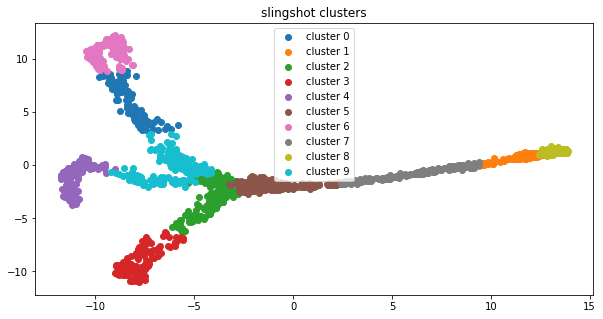

In [14]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [15]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 8)

R[write to console]: Using full covariance matrix


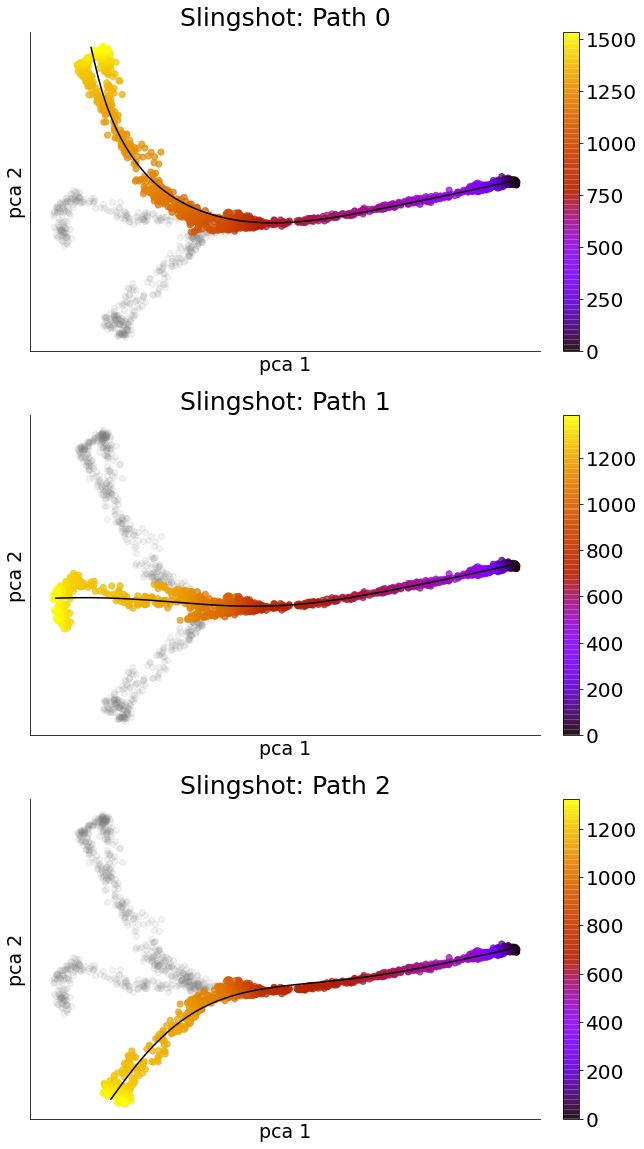

In [16]:
kt_slingshot = visual.slingshot_visual(adata,  results, basis= "pca", figsize=(10,20), save_as = None)

[Text(0, 0, ''),
 Text(0, 0, 'CellPaths'),
 Text(0, 0, 'Slingshot'),
 Text(0, 0, '')]

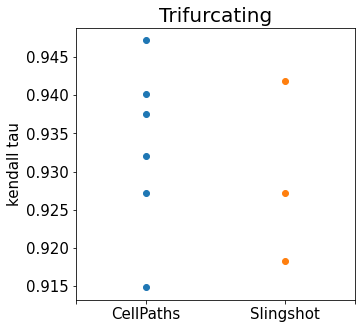

In [17]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
# ax.scatter(["CellPaths" for x in kt.values()], [x for x in kt.values()])
# ax.scatter(["slingshot" for x in kt_slingshot.values()], [x for x in kt_slingshot.values()])

ax.scatter([0 for x in kt.values()], [x for x in kt.values()])
ax.scatter([1 for x in kt_slingshot.values()], [x for x in kt_slingshot.values()])

ax.set_title("Trifurcating", fontsize = 20)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks([-0.5,0,1,1.5],fontsize = 15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = ""
labels[1] = "CellPaths"
labels[2] = "Slingshot"
labels[3] = ""
ax.set_xticklabels(labels)
# fig.savefig("./sim_results/Dyngen/Trifurcating/quantity/boxplot.pdf", bbox_inches = "tight")

In [18]:
f1_slingshot = bmk.f1_score(adata = adata, method="Slingshot", slingshot_result = results, trajs = 3)

recovery

inferred trajectory: 0 jaccard: 0.2834850455136541
inferred trajectory: 1 jaccard: 0.2984104046242775
inferred trajectory: 2 jaccard: 0.273620559334845
recovery value: 0.2851720031575922
relevence

ori trajectory: 1 jaccard: 0.273620559334845
ori trajectory: 2 jaccard: 0.2834850455136541
ori trajectory: 3 jaccard: 0.2660619803476946
ori trajectory: 4 jaccard: 0.2984104046242775
ori trajectory: 5 jaccard: 0.2824675324675325
relevence value: 0.28080910445760077


In [19]:
bmk_belongings = bmk.purity_count(adata = adata, method = "Slingshot", slingshot_result = results, trajs = 3)
entro_slingshot = bmk.average_entropy(bmk_belongings)
entro_slingshot

1.5680393614697745

## Trajectory assignment result

In [20]:
print("f1 score of cellpath: " + str(f1) + ", f1 score of slingshot: " + str(f1_slingshot))

f1 score of cellpath: 0.3009956752064266, f1 score of slingshot: 0.28297373797681147


In [21]:
print("Average entropy of cellpath: " + str(entro) + ", Average antropy of slingshot: " + str(entro_slingshot))

Average entropy of cellpath: 1.5483575923850414, Average antropy of slingshot: 1.5680393614697745
